In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!git clone https://github.com/realcrane/iPLAN-Interactive-and-Procedural-Layout-Planning

Cloning into 'iPLAN-Interactive-and-Procedural-Layout-Planning'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 301 (delta 96), reused 106 (delta 46), pack-reused 91
Receiving objects: 100% (301/301), 12.98 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [3]:
import torch

In [4]:
import os
print("Directory di lavoro corrente:", os.getcwd())
roomType_directory = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_type'
os.chdir(roomType_directory)
print("Nuova directory di lavoro:", os.getcwd())

Directory di lavoro corrente: /content
Nuova directory di lavoro: /content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_type


In [5]:
path_model_roomType = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_type/roomtype_cvae_150.pth"

In [6]:
from config_roomtype import RoomTypeConfig
opt = RoomTypeConfig()

In [7]:
import models
cvae = models.cvae(
        modul_name=opt.module_name,
        model_name=opt.model_name,
        input_dim=opt.max_room_num,
        hidden_dim1=128,
        hidden_dim2=64,
        z_dim=opt.noise_dim
    )
print(cvae)
cvae.load_model(path_model_roomType)

CVAE(
  (fc1): Linear(in_features=83, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc31): Linear(in_features=64, out_features=32, bias=True)
  (fc32): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=96, out_features=96, bias=True)
  (fc5): Linear(in_features=96, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=19, bias=True)
  (relu): ReLU()
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_run

In [8]:
cvae.cuda()
cvae.eval()
print()

In [9]:
from dataset import RoomTypeDataset
from torch.utils.data import DataLoader

opt.num_workers = 2 #original is 16
val_data = RoomTypeDataset(data_root=opt.data_root, phase='test', max_room_per_type=opt.max_room_per_type)

val_dataloader = DataLoader(
        val_data,
        batch_size=opt.batch_size,
        shuffle=False,
        num_workers=opt.num_workers
    )

In [10]:
import torch.nn.functional as F
import torch as t
def loss_function(recon_x, x, mu, log_var):
    """return reconstruction error + KL divergence losses"""
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * t.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD * 0.5, BCE, KLD

In [11]:
for batch_idx, (input_img, input_vector) in enumerate(val_dataloader):
  input_img = input_img.to("cuda")
  input_vector = input_vector.to("cuda")
  recon, mu, log_var = cvae(input_vector, input_img)
  loss, bce_loss, kld_loss = loss_function(recon, input_vector, mu, log_var)

In [12]:
print(recon, mu, log_var )

tensor([[1.0000e+00, 9.9999e-01, 4.3617e-01, 9.9993e-01, 9.9956e-01, 3.1867e-03,
         1.9311e-04, 9.1324e-01, 1.8141e-02, 8.8390e-01, 2.3655e-05, 4.7688e-14,
         2.8164e-03, 9.9704e-01, 5.9728e-06, 1.3980e-16, 6.6073e-03, 2.5087e-04,
         9.8643e-03],
        [1.0000e+00, 9.9995e-01, 4.8353e-19, 1.0000e+00, 9.9988e-01, 6.7547e-07,
         8.1903e-11, 1.9252e-17, 2.2534e-04, 1.0000e+00, 1.2240e-02, 2.6716e-10,
         3.5810e-29, 9.9998e-01, 3.7078e-04, 1.3313e-15, 1.6842e-11, 4.4125e-06,
         1.9856e-15]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[ 1.5889e-04,  7.7239e-03, -4.7104e-03,  1.0581e+00, -7.5289e-01,
         -8.3118e-03, -2.0549e-03,  1.5421e-03, -1.8611e-03,  4.0714e-03,
          2.8192e-03, -4.6781e-03, -2.9286e-04,  1.2266e-03,  4.6851e-04,
          3.7099e-03, -4.9546e-01, -3.7998e-03,  5.7378e-03,  2.7480e-03,
          1.0418e+00, -1.1927e+00, -5.1561e-03,  3.0592e-04,  2.9517e-03,
          1.8346e-03, -5.5150e-03, -1.6141e-03, -1.564

In [ ]:
print("------------------------------------------------")
print(f"|Loss: {loss.item()}                        |")
print("------------------------------------------------")
print(f"|Binary cross entropy: {bce_loss.item()}.      |")
print("------------------------------------------------")
print(f"|Kullback-Leibler divergence: { kld_loss.item()} |")
print("------------------------------------------------")

------------------------------------------------
|Loss: 5.173709869384766                        |
------------------------------------------------
|Binary cross entropy: 1.7538410425186157.      |
------------------------------------------------
|Kullback-Leibler divergence: 6.839737892150879 |
------------------------------------------------


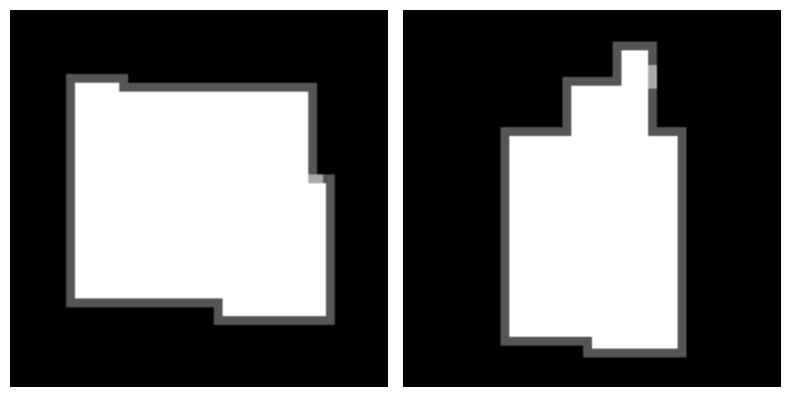

In [ ]:
import matplotlib.pyplot as plt

img = torch.cat((input_img[0], input_img[1]), dim=0)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].cpu(), cmap='gray')
    ax.grid("off")
    ax.axis('off')

plt.tight_layout()
plt.show()